In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import warnings

warnings.filterwarnings("ignore")

# Basic Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modelling
# Classification
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

# Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering

# Ranking
import lightgbm as lgb

# Model Selection
from sklearn.model_selection import train_test_split, GridSearchCV

# Metrics
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
)

# Balancing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Binning
import woeBinningPandas

# Create Unique ID
import uuid

<IPython.core.display.Javascript object>

Data: https://www.kaggle.com/wordsforthewise/lending-club

In [3]:
# Read data
accepted = pd.read_csv("accepted_2007_to_2018Q4.csv", low_memory=False)
rejected = pd.read_csv("rejected_2007_to_2018Q4.csv", low_memory=False)

<IPython.core.display.Javascript object>

In [4]:
print(accepted.shape)
print(rejected.shape)

(2260701, 151)
(27648741, 9)


<IPython.core.display.Javascript object>

## Preprocessing

In [5]:
# Sample 100k obs. for easy processing
accepted_small = accepted.sample(n=25000, random_state=7)
accepted_small.reset_index(drop=True, inplace=True)

<IPython.core.display.Javascript object>

In [6]:
# Create Default Flag
accepted_small["target"] = accepted_small["loan_status"].apply(
    lambda x: 1 if x == "Charged Off" else (0 if x == "Fully Paid" else 2)
)

<IPython.core.display.Javascript object>

In [7]:
# Remove Current and Missings
accepted_small = accepted_small.loc[accepted_small["target"] != 2]
accepted_small.shape

(14838, 152)

<IPython.core.display.Javascript object>

In [8]:
pd.crosstab(accepted_small["target"], accepted_small["loan_status"])

loan_status,Charged Off,Fully Paid
target,,
0,0,11809
1,3029,0


<IPython.core.display.Javascript object>

The dataset is imbalanced

## Bucketing

In [9]:
# Keep only 2 explanatory variables for quick an dirty PD model
df = accepted_small[
    ["id", "target", "loan_amnt", "addr_state", "emp_length", "annual_inc"]
]

<IPython.core.display.Javascript object>

In [10]:
# Create Debt to Income and delete input variable from dataset
df["DTI"] = df["loan_amnt"] / df["annual_inc"]
del df["annual_inc"]

<IPython.core.display.Javascript object>

In [11]:
# DTI2
df["DTI2"] = df["DTI"].apply(
    lambda x: "<=0.1"
    if (x <= 0.1)
    else (
        "0.1-0.2"
        if (x > 0.1 and x <= 0.2)
        else (
            "0.2-0.3"
            if (x > 0.2 and x <= 0.3)
            else ("0.3-0.4" if (x > 0.3 and x <= 0.4) else ">0.4")
        )
    )
)

<IPython.core.display.Javascript object>

In [12]:
# State
binning_emp_length = woeBinningPandas.woe_binning(
    df, "target", "emp_length", 0.1, 0.1, 50, 100, "bad"
)
binning_emp_length

,Group_2,Group_1,woe,iv_total_final,good,bad,col_perc_a,col_perc_b,iv_bins
2,misc. level neg.,2 years,-11.550008,0.006977,3654,1052,0.309425,0.347309,0.004376
0,misc. level neg.,1 year,-11.550008,0.006977,3654,1052,0.309425,0.347309,0.004376
4,misc. level neg.,4 years,-11.550008,0.006977,3654,1052,0.309425,0.347309,0.004376
11,misc. level neg.,Missing,-11.550008,0.006977,3654,1052,0.309425,0.347309,0.004376
8,misc. level neg.,8 years,-11.550008,0.006977,3654,1052,0.309425,0.347309,0.004376
1,10+ years,10+ years,2.904113,0.006977,3857,961,0.326615,0.317266,0.000272
9,misc. level pos.,9 years,8.164703,0.006977,4298,1016,0.363960,0.335424,0.002330
7,misc. level pos.,7 years,8.164703,0.006977,4298,1016,0.363960,0.335424,0.002330
6,misc. level pos.,6 years,8.164703,0.006977,4298,1016,0.363960,0.335424,0.002330
5,misc. level pos.,5 years,8.164703,0.006977,4298,1016,0.363960,0.335424,0.002330


<IPython.core.display.Javascript object>

In [13]:
bademplen = binning_emp_length["Group_1"][:2].tolist()
nullemplen = binning_emp_length["Group_1"][2:].tolist()

<IPython.core.display.Javascript object>

In [14]:
# Emp Length
df["emp_length2"] = df["emp_length"].apply(
    lambda x: "1-2 years" if (x in nullemplen) else ">2 years"
)

<IPython.core.display.Javascript object>

In [15]:
# Loan Amount
df["loan_amnt2"] = df["loan_amnt"].apply(
    lambda x: "<=1k"
    if (x <= 1000)
    else ("1-10k" if (x > 1000 and x <= 10000) else ">10k")
)

<IPython.core.display.Javascript object>

In [16]:
# State
binning = woeBinningPandas.woe_binning(
    df, "target", "addr_state", 0.1, 0.1, 50, 100, "bad"
)
binning

,Group_2,Group_1,woe,iv_total_final,good,bad,col_perc_a,col_perc_b,iv_bins
37,misc. level neg.,PA,-15.802180,0.024348,4880,1466,0.413244,0.483988,0.011179
34,misc. level neg.,OH,-15.802180,0.024348,4880,1466,0.413244,0.483988,0.011179
26,misc. level neg.,NC,-15.802180,0.024348,4880,1466,0.413244,0.483988,0.011179
19,misc. level neg.,MD,-15.802180,0.024348,4880,1466,0.413244,0.483988,0.011179
30,misc. level neg.,NJ,-15.802180,0.024348,4880,1466,0.413244,0.483988,0.011179
14,misc. level neg.,IN,-15.802180,0.024348,4880,1466,0.413244,0.483988,0.011179
23,misc. level neg.,MO,-15.802180,0.024348,4880,1466,0.413244,0.483988,0.011179
32,misc. level neg.,NV,-15.802180,0.024348,4880,1466,0.413244,0.483988,0.011179
1,misc. level neg.,AL,-15.802180,0.024348,4880,1466,0.413244,0.483988,0.011179
41,misc. level neg.,TN,-15.802180,0.024348,4880,1466,0.413244,0.483988,0.011179


<IPython.core.display.Javascript object>

In [17]:
badstates = binning["Group_1"][:25].tolist()
california = ["CA"]
goodstates = binning["Group_1"][27:].tolist()

<IPython.core.display.Javascript object>

In [18]:
df["addr_state2"] = df["addr_state"].apply(
    lambda x: "California"
    if (x == "CA")
    else ("Bad state" if (x in badstates) else "Good state")
)

<IPython.core.display.Javascript object>

In [19]:
df2 = df[["id", "target", "loan_amnt2", "addr_state2", "emp_length2", "DTI2"]]

<IPython.core.display.Javascript object>

In [20]:
# Function to apply the bucketing to any future dataset:


def binning(data):
    data["loan_amnt2"] = data["loan_amnt"].apply(
        lambda x: "<=1k"
        if (x <= 1000)
        else ("1-10k" if (x > 1000 and x <= 10000) else ">10k")
    )

    data["addr_state2"] = data["addr_state"].apply(
        lambda x: "California"
        if (x == "CA")
        else ("Bad state" if (x in badstates) else "Good state")
    )

    data["emp_length2"] = data["emp_length"].apply(
        lambda x: "1-2 years" if (x in nullemplen) else ">2 years"
    )

    data["DTI2"] = data["DTI"].apply(
        lambda x: "<=0.1"
        if (x <= 0.1)
        else (
            "0.1-0.2"
            if (x > 0.1 and x <= 0.2)
            else (
                "0.2-0.3"
                if (x > 0.2 and x <= 0.3)
                else ("0.3-0.4" if (x > 0.3 and x <= 0.4) else ">0.4")
            )
        )
    )

    data = data[["id", "loan_amnt2", "addr_state2", "emp_length2", "DTI2"]]
    return data

<IPython.core.display.Javascript object>

In [21]:
# Function to explore differentiation of bucketing visually + cross tab:


def diff_visual(data, variable):
    %matplotlib inline
    table = pd.crosstab(data[variable], df2["target"])
    table.div(table.sum(1).astype(float), axis=0).plot(
        kind="bar", color=["cadetblue", "crimson"], stacked=True
    )
    plt.title("Stacked Bar Loan Amount vs Default Status")
    # plt.xlabel(variable)
    plt.ylabel("Proportion of Accepts")

    x = pd.crosstab(data[variable], df2["target"]).apply(lambda r: r / r.sum(), axis=1)
    x = pd.DataFrame(x)

    y = pd.crosstab(df[variable], df["target"])
    y = pd.DataFrame(y)

    return x, y

<IPython.core.display.Javascript object>

(target             0         1
 loan_amnt2                    
 1-10k       0.823922  0.176078
 <=1k        0.892308  0.107692
 >10k        0.775151  0.224849,
 target         0     1
 loan_amnt2            
 1-10k       5063  1082
 <=1k          58     7
 >10k        6688  1940)

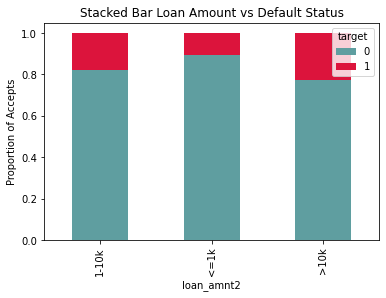

<IPython.core.display.Javascript object>

In [22]:
diff_visual(df2, "loan_amnt2")

(target              0         1
 emp_length2                    
 1-2 years    0.801798  0.198202
 >2 years     0.773908  0.226092,
 target          0     1
 emp_length2            
 1-2 years    9365  2315
 >2 years     2444   714)

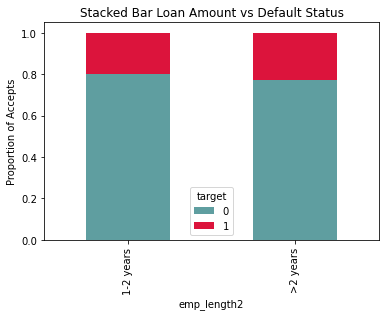

<IPython.core.display.Javascript object>

In [23]:
diff_visual(df2, "emp_length2")

(target              0         1
 addr_state2                    
 Bad state    0.779883  0.220117
 California   0.793533  0.206467
 Good state   0.823040  0.176960,
 target          0     1
 addr_state2            
 Bad state    6133  1731
 California   1718   447
 Good state   3958   851)

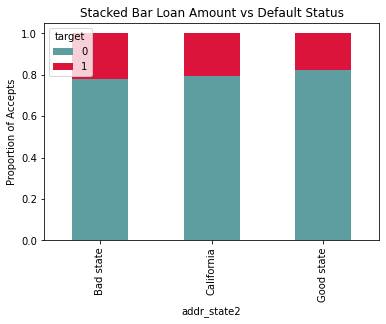

<IPython.core.display.Javascript object>

In [24]:
diff_visual(df2, "addr_state2")

(target          0         1
 DTI2                       
 0.1-0.2  0.831073  0.168927
 0.2-0.3  0.781790  0.218210
 0.3-0.4  0.715391  0.284609
 <=0.1    0.860377  0.139623
 >0.4     0.692008  0.307992,
 target      0    1
 DTI2              
 0.1-0.2  4167  847
 0.2-0.3  2988  834
 0.3-0.4  1664  662
 <=0.1    2280  370
 >0.4      710  316)

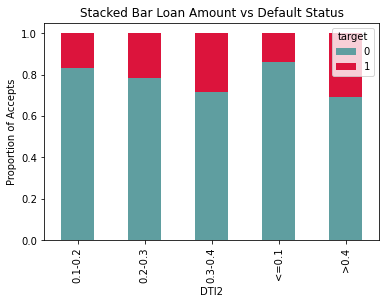

<IPython.core.display.Javascript object>

In [25]:
diff_visual(df2, "DTI2")

In [26]:
# One hot encoding
modelling_variables = ["target", "loan_amnt2", "addr_state2", "emp_length2", "DTI2"]

for i in modelling_variables:
    if i != "target":
        df2 = df2.join(pd.get_dummies(df2[i]))
        df2 = df2.drop([i], axis=1)

<IPython.core.display.Javascript object>

In [27]:
# Drop Null Band
df3 = df2.drop(columns=["1-10k", "California", ">2 years", "0.2-0.3"])

<IPython.core.display.Javascript object>

In [28]:
X = df3.loc[:, df3.columns != "target"]
y = df3.loc[:, df3.columns == "target"]

<IPython.core.display.Javascript object>

In [29]:
# Balance the data
os = RandomUnderSampler(sampling_strategy=0.5, random_state=7)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)
columns = X_train.columns

<IPython.core.display.Javascript object>

In [30]:
# Train
os_data_X, os_data_y = os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
os_data_y = pd.DataFrame(data=os_data_y, columns=["target"])

# we can check the numbers of our data
print(
    "The number of observations in Development data before undersampling is ",
    len(X_train),
)
print(
    "The number of observations in Development data after undersampling is ",
    len(os_data_X),
)

The number of observations in Development data before undersampling is  10386
The number of observations in Development data after undersampling is  6357


<IPython.core.display.Javascript object>

In [31]:
# Keep only columns for modelling
os_data_X_2 = os_data_X[
    [
        "Good state",
        "Bad state",
        "1-2 years",
        "<=0.1",
        "0.1-0.2",
        "0.3-0.4",
        ">0.4",
    ]
]
X_test_2 = X_test[
    [
        "Good state",
        "Bad state",
        "1-2 years",
        "<=0.1",
        "0.1-0.2",
        "0.3-0.4",
        ">0.4",
    ]
]

<IPython.core.display.Javascript object>

In [32]:
# Build Logistic regression
# Statmodels
logit_model = sm.Logit(os_data_y, os_data_X_2.astype(float))
result3 = logit_model.fit()
print(result3.summary2())

Optimization terminated successfully.
         Current function value: 0.623719
         Iterations 5
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.020     
Dependent Variable: target           AIC:              7943.9672 
Date:               2020-11-21 12:05 BIC:              7991.2684 
No. Observations:   6357             Log-Likelihood:   -3965.0   
Df Model:           6                LL-Null:          -4046.3   
Df Residuals:       6350             LLR p-value:      1.6070e-32
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Good state    -0.4791    0.0675  -7.0950  0.0000  -0.6114  -0.3467
Bad state     -0.1707    0.0593  -2.8788  0.0040  -0.2870  -0.

<IPython.core.display.Javascript object>

Accuracy score Logistic Regression: 0.7821203953279425


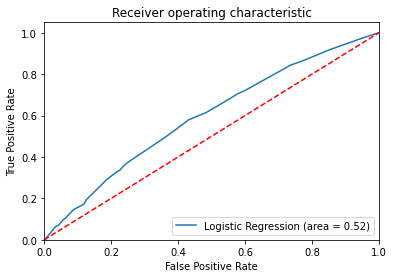

<IPython.core.display.Javascript object>

In [33]:
# Sklearn
logreg = LogisticRegression(fit_intercept=False, penalty="none")
logreg.fit(os_data_X_2, os_data_y.values.ravel())
y_pred = logreg.predict(X_test_2)
print("Accuracy score Logistic Regression:", logreg.score(X_test_2, y_test))
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test_2))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test_2)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.savefig("Log_ROC")
plt.show()

In [34]:
#Test set with labels
test_labels = pd.merge(
    y_test,
    X_test,
    how="inner",
    left_index=True,
    right_index=True,
)


<IPython.core.display.Javascript object>

In [35]:
# Predictions on testset
test_pred = logreg.predict_proba(X_test_2)[:, 1]
test_pred2 = pd.DataFrame(data=test_pred, columns=["prediction"])
test_pred2["count"] = test_pred2.groupby("prediction")["prediction"].transform("count")
test_pred2.groupby(["prediction"]).count()

,count
prediction,
0.183686,202
0.227846,390
0.234465,321
0.241186,51
0.266478,105
0.286547,603
0.294187,101
0.301980,91
0.304834,311


<IPython.core.display.Javascript object>

In [36]:
# Join predictions with test new
pred_test_kgb = pd.DataFrame(
    data=test_pred, columns=["prediction_beforeRI"], index=y_test.index.copy()
)
pred_test1 = pd.merge(
    test_labels,
    pred_test_kgb[["prediction_beforeRI"]],
    how="inner",
    left_index=True,
    right_index=True,
)

# pred_test1.dropna(subset=["prediction_beforeRI"], inplace=True)
pred_test1

,target,id,<=1k,>10k,Bad state,Good state,1-2 years,0.1-0.2,0.3-0.4,<=0.1,>0.4,prediction_beforeRI
11341,0,26789777,0,1,0,0,1,0,0,0,0,0.414503
3076,1,17894572,0,1,0,0,1,0,1,0,0,0.477733
10395,0,34773392,0,1,0,0,1,1,0,0,0,0.322674
15834,0,1122926,0,1,0,1,1,1,0,0,0,0.227846
1317,0,46774382,0,1,1,0,1,0,0,0,1,0.468103
...,...,...,...,...,...,...,...,...,...,...,...,...
10236,0,98857570,0,1,0,1,1,1,0,0,0,0.227846
6184,1,94467429,0,1,1,0,0,0,0,0,0,0.457428
13619,1,124747082,0,1,1,0,0,0,1,0,0,0.521375
4441,1,49673413,0,1,1,0,1,1,0,0,0,0.286547


<IPython.core.display.Javascript object>

In [37]:
pred_test1.shape  # Expected nr. of observations

(4452, 12)

<IPython.core.display.Javascript object>

### Random Forest

In [38]:
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(os_data_X_2, os_data_y.values.ravel())
y_pred = rf.predict(X_test_2)
print("Accuracy score Random Forest:", rf.score(X_test_2, y_test))

Accuracy score Random Forest: 0.7955974842767296


<IPython.core.display.Javascript object>

### Decision Tree

In [39]:
from sklearn.metrics import confusion_matrix

<IPython.core.display.Javascript object>

In [40]:
dt = DecisionTreeClassifier(random_state=0)
dt.fit(os_data_X_2, os_data_y.values.ravel())
y_pred = dt.predict(X_test_2)
print("Accuracy score Decision Tree:", dt.score(X_test_2, y_test))

Accuracy score Decision Tree: 0.7845911949685535


<IPython.core.display.Javascript object>

### SVM

In [41]:
svm = svm.SVC()
svm.fit(os_data_X_2, os_data_y.values.ravel())
y_pred = svm.predict(X_test_2)
print("Accuracy score SVM:", svm.score(X_test_2, y_test))

Accuracy score SVM: 0.7854896675651393


<IPython.core.display.Javascript object>

### K-Means

In [42]:
km = KMeans(n_clusters=2)
km.fit(os_data_X_2, os_data_y.values.ravel())
y_pred = km.predict(X_test_2)

<IPython.core.display.Javascript object>

### Hierarchical clustering

In [43]:
hc = AgglomerativeClustering(n_clusters=2, affinity="euclidean", linkage="ward")
hc.fit_predict(os_data_X_2, os_data_y.values.ravel())
y_pred = km.predict(X_test_2)

<IPython.core.display.Javascript object>

### Light GBM Ranker

In [44]:
X_train_GBM, X_val, y_train_GBM, y_val = train_test_split(
    os_data_X_2, os_data_y, test_size=0.2, random_state=1
)

<IPython.core.display.Javascript object>

In [45]:
gbm = lgb.LGBMRanker()

query_train = [X_train_GBM.shape[0]]
query_val = [X_val.shape[0]]
query_test = [X_test_2.shape[0]]

gbm.fit(
    X_train_GBM,
    y_train_GBM,
    group=query_train,
    eval_set=[(X_val, y_val)],
    eval_group=[query_val],
    eval_at=[5, 10, 20],
    early_stopping_rounds=50,
)

y_pred = gbm.predict(X_test_2)

[1]	valid_0's ndcg@5: 0	valid_0's ndcg@10: 0.214084	valid_0's ndcg@20: 0.210122
Training until validation scores don't improve for 50 rounds
[2]	valid_0's ndcg@5: 0.131205	valid_0's ndcg@10: 0.294192	valid_0's ndcg@20: 0.508985
[3]	valid_0's ndcg@5: 0.131205	valid_0's ndcg@10: 0.148764	valid_0's ndcg@20: 0.163856
[4]	valid_0's ndcg@5: 0.131205	valid_0's ndcg@10: 0.294192	valid_0's ndcg@20: 0.508985
[5]	valid_0's ndcg@5: 0.131205	valid_0's ndcg@10: 0.148764	valid_0's ndcg@20: 0.277458
[6]	valid_0's ndcg@5: 0.131205	valid_0's ndcg@10: 0.148764	valid_0's ndcg@20: 0.231883
[7]	valid_0's ndcg@5: 0.131205	valid_0's ndcg@10: 0.294192	valid_0's ndcg@20: 0.508985
[8]	valid_0's ndcg@5: 0.131205	valid_0's ndcg@10: 0.148764	valid_0's ndcg@20: 0.231883
[9]	valid_0's ndcg@5: 0.131205	valid_0's ndcg@10: 0.148764	valid_0's ndcg@20: 0.231883
[10]	valid_0's ndcg@5: 0.131205	valid_0's ndcg@10: 0.148764	valid_0's ndcg@20: 0.345485
[11]	valid_0's ndcg@5: 0.131205	valid_0's ndcg@10: 0.148764	valid_0's ndcg@

<IPython.core.display.Javascript object>

In [46]:
X_test_2["prediction_beforeRI"] = test_pred
X_test_2.sort_values("prediction_beforeRI", ascending=False)

,Good state,Bad state,1-2 years,<=0.1,0.1-0.2,0.3-0.4,>0.4,prediction_beforeRI
715,0,0,0,0,0,0,1,0.595879
2007,0,0,0,0,0,0,1,0.595879
24852,0,0,0,0,0,0,1,0.595879
21918,0,0,0,0,0,0,1,0.595879
16509,0,0,0,0,0,0,1,0.595879
...,...,...,...,...,...,...,...,...
10439,1,0,1,1,0,0,0,0.183686
11362,1,0,1,1,0,0,0,0.183686
12593,1,0,1,1,0,0,0,0.183686
18571,1,0,1,1,0,0,0,0.183686


<IPython.core.display.Javascript object>

(array([ 202.,  762., 1211.,  219.,  869.,  251.,  624.,  156.,  136.,
          22.]),
 array([0.18368646, 0.22490569, 0.26612491, 0.30734413, 0.34856335,
        0.38978258, 0.4310018 , 0.47222102, 0.51344024, 0.55465947,
        0.59587869]),
 <a list of 10 Patch objects>)

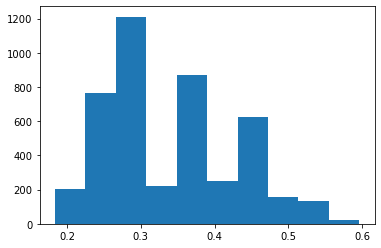

<IPython.core.display.Javascript object>

In [47]:
plt.hist(X_test_2["prediction_beforeRI"], bins=10)

## Apply the KGB Model to the Rejects

In [48]:
# Sampling
rejected_small = rejected.sample(n=10000, random_state=7)
rejected_small.reset_index(drop=True, inplace=True)
rejected_small.rename(columns={"Amount Requested": "loan_amnt"}, inplace=True)
rejected_small.rename(columns={"Employment Length": "emp_length_new"}, inplace=True)
rejected_small.rename(columns={"State": "addr_state"}, inplace=True)
rejected_small.rename(columns={"Debt-To-Income Ratio": "DTI"}, inplace=True)
rejected_small["DTI"] = pd.to_numeric(rejected_small["DTI"].str[:-1])
dfr = rejected_small[["loan_amnt", "addr_state", "emp_length_new", "DTI"]]

<IPython.core.display.Javascript object>

In [49]:
# Create unique id for the rejects (to facilitate merge later)
dfr["id"] = dfr.index.to_series().map(lambda x: uuid.uuid4())

<IPython.core.display.Javascript object>

In [50]:
# Map values of emp. length of accepts to the rejects
dfr["emp_length"] = dfr["emp_length_new"].apply(
    lambda x: "< 1 year"  # match name
    if (x == "1 year" or x == "< 1 year" or x == "2 years")
    else ">2 years"
)
del dfr["emp_length_new"]

<IPython.core.display.Javascript object>

In [51]:
# Train/Test Split (without labels)

# Shuffle the dataset
shuffle_df = dfr.sample(frac=1)

# Define a size for your train set
train_size = int(0.7 * len(shuffle_df))

# Split your dataset
dfr_dev = shuffle_df[:train_size]
dfr_test = shuffle_df[train_size:]

<IPython.core.display.Javascript object>

In [52]:
# Bucketing Train set (based on the custom function)
binning(dfr_dev)

,id,loan_amnt2,addr_state2,emp_length2,DTI2
8159,93529636-ff3c-44d9-87a8-3c47a29d5cb5,>10k,Bad state,1-2 years,>0.4
314,2e48aed7-2602-4715-a1b0-6a19abb47910,1-10k,Good state,1-2 years,>0.4
6891,447d0bc7-3810-43a5-934b-76990c5a3332,1-10k,Bad state,1-2 years,>0.4
6241,923a2267-ab11-4466-a40f-87a409c4c0da,1-10k,Bad state,1-2 years,>0.4
2421,318d53e2-895f-4aeb-b8e9-449f4f2cd39d,>10k,California,1-2 years,>0.4
...,...,...,...,...,...
9292,f3bcc1ee-7517-4ce4-9267-da4f71c11499,>10k,California,1-2 years,>0.4
9845,d18bc3d1-fb12-433a-b58b-f91461bf1a71,1-10k,Bad state,1-2 years,>0.4
7499,c43557d8-78b7-46ad-bb9e-e3bc09c53981,>10k,California,1-2 years,>0.4
2618,b99ea0cf-8e7f-4ff2-8a93-fa2327771609,>10k,California,1-2 years,>0.4


<IPython.core.display.Javascript object>

In [53]:
# One hot encoding
modelling_variables = ["target", "loan_amnt2", "addr_state2", "emp_length2", "DTI2"]

for i in modelling_variables:
    if i != "target":
        dfr_dev = dfr_dev.join(pd.get_dummies(dfr_dev[i]))
        dfr_dev = dfr_dev.drop([i], axis=1)

<IPython.core.display.Javascript object>

In [54]:
# Drop Null Band
dfr_dev2 = dfr_dev.drop(
    columns=[
        "loan_amnt",
        "addr_state",
        "emp_length",
        "1-10k",
        "California",
        ">2 years",
        "0.2-0.3",
    ]
)

<IPython.core.display.Javascript object>

In [55]:
# Bucketing (based on a custom function)
binning(dfr_test)

,id,loan_amnt2,addr_state2,emp_length2,DTI2
4796,48989448-1ffc-49a6-86a0-4fa2ce3bd2e9,1-10k,Bad state,1-2 years,>0.4
6285,559f012a-a910-4715-a7c8-fcbb0ef2cc7d,1-10k,Bad state,>2 years,>0.4
4540,b3a64f5b-54f4-46c3-aabf-e9af10d544ef,>10k,Good state,1-2 years,>0.4
3837,1db19341-6f69-4978-832c-d64d386f09ab,>10k,Good state,1-2 years,>0.4
4303,95b130bb-0013-4e37-bdea-293869491cc8,1-10k,Bad state,1-2 years,>0.4
...,...,...,...,...,...
8462,a82464db-dfac-45b9-87dc-bfd4649a4517,>10k,Good state,1-2 years,>0.4
9189,1fccc4f2-5bf1-42c3-8923-728bd1c1111e,<=1k,Bad state,1-2 years,>0.4
8874,84e4b179-12b4-49b1-b8ae-6632f502c138,>10k,Good state,>2 years,>0.4
3617,1a0d8552-9066-49e9-8889-733b56f17a68,>10k,Bad state,1-2 years,>0.4


<IPython.core.display.Javascript object>

In [56]:
# One hot encoding
modelling_variables = ["target", "loan_amnt2", "addr_state2", "emp_length2", "DTI2"]

for i in modelling_variables:
    if i != "target":
        dfr_test = dfr_test.join(pd.get_dummies(dfr_test[i]))
        dfr_test = dfr_test.drop([i], axis=1)

<IPython.core.display.Javascript object>

In [57]:
# Drop Null Band
dfr_test2 = dfr_test.drop(
    columns=[
        "loan_amnt",
        "addr_state",
        "emp_length",
        "1-10k",
        "California",
        ">2 years",
        "0.2-0.3",
    ]
)

<IPython.core.display.Javascript object>

In [58]:
dfr_dev3 = dfr_dev2[
    [
        "Good state",
        "Bad state",
        "1-2 years",
        "<=0.1",
        "0.1-0.2",
        "0.3-0.4",
        ">0.4",
    ]
]
dfr_test3 = dfr_test2[
    [
        "Good state",
        "Bad state",
        "1-2 years",
        "<=0.1",
        "0.1-0.2",
        "0.3-0.4",
        ">0.4",
    ]
]

<IPython.core.display.Javascript object>

### Function for predictions

Predictions1 uses predict_proba; predictions 2 uses predict

In [59]:
def predictions1(model, treshold):
    # Join predictions with train new
    pred = model.predict_proba(dfr_dev3)[:, 1]
    pred2 = pd.DataFrame(
        data=pred,
        columns=["prediction2"],
        index=dfr_dev2.index.copy(),
    )
    pred2["prediction_beforeRI"] = pred2["prediction2"].apply(
        lambda x: 0 if (x < treshold) else 1
    )
    outcome = pd.merge(
        dfr_dev2,
        pred2[["prediction_beforeRI"]],
        how="inner",
        left_index=True,
        right_index=True,
    )
    # pred_test1.dropna(subset=["prediction_beforeRI"], inplace=True)
    outcome = outcome[["id", "prediction_beforeRI"]]
    return outcome

<IPython.core.display.Javascript object>

In [60]:
def predictions2(model, treshold):
    # Join predictions with train new
    pred = model.predict(dfr_dev3)
    pred2 = pd.DataFrame(
        data=pred,
        columns=["prediction2"],
        index=dfr_dev2.index.copy(),
    )
    pred2["prediction_beforeRI"] = pred2["prediction2"].apply(
        lambda x: 0 if (x < treshold) else 1
    )
    outcome = pd.merge(
        dfr_dev2,
        pred2[["prediction_beforeRI"]],
        how="inner",
        left_index=True,
        right_index=True,
    )
    # pred_test1.dropna(subset=["prediction_beforeRI"], inplace=True)
    outcome = outcome[["id", "prediction_beforeRI"]]
    return outcome

<IPython.core.display.Javascript object>

### Predictions

In [61]:
ri1_train = predictions1(logreg, 0.3)  # Logistic Regression
ri2_train = predictions1(dt, 0.3)  # Decision Tree
ri3_train = predictions1(rf, 0.3)  # Random Forest
ri4_train = predictions2(svm, 0.3)  # SVM
ri5_train = predictions2(km, 0.3)  # K-means on Accepts
ri8_train = predictions2(gbm, 0.2)  # Light GBM ranking 0.2
ri9_train = predictions2(gbm, 0.1)  # Light GBM ranking 0.1

<IPython.core.display.Javascript object>

### K-Means

to-do:
- grid search/hypterparameter optimization
- visualization

In [62]:
kmeans = KMeans(
    init="random", n_clusters=2, n_init=10, max_iter=300, random_state=7
).fit(dfr_dev3)

<IPython.core.display.Javascript object>

In [63]:
print("Inertia: ", kmeans.inertia_)
print("Cluster centers: ", kmeans.cluster_centers_)
print("N iter: ", kmeans.n_iter_)
print("Labels: ", kmeans.labels_)

Inertia:  2599.100531683631
Cluster centers:  [[ 7.28633189e-01 -1.11022302e-15  8.53009644e-01  8.74625873e-02
   2.32790156e-03  2.32790156e-03  9.06551380e-01]
 [ 1.05471187e-15  1.00000000e+00  8.55747558e-01  8.16428750e-02
   5.00876534e-04  2.75482094e-03  9.14099674e-01]]
N iter:  2
Labels:  [1 0 1 ... 0 0 0]


<IPython.core.display.Javascript object>

### Reject Inference K-means

### Train set

In [64]:
# Predictions
rej_test_predictions_kmeans = kmeans.labels_
df_pred_rej_kmeans = pd.DataFrame(
    data=rej_test_predictions_kmeans, columns=["prediction"]
)
df_pred_rej_kmeans["Rejects"] = df_pred_rej_kmeans.groupby("prediction")[
    "prediction"
].transform("count")
df_pred_rej_kmeans.groupby(["prediction"]).count()

,Rejects
prediction,
0,3007
1,3993


<IPython.core.display.Javascript object>

In [65]:
# Join predictions with train new
pred_ri = kmeans.labels_
pred_ri2 = pd.DataFrame(
    data=pred_ri, columns=["prediction_beforeRI"], index=dfr_dev2.index.copy()
)
ri6 = pd.merge(
    dfr_dev2,
    pred_ri2[["prediction_beforeRI"]],
    how="inner",
    left_index=True,
    right_index=True,
)
# pred_test1.dropna(subset=["prediction_beforeRI"], inplace=True)
ri6_train = ri6[["id", "prediction_beforeRI"]]
ri6_train

,id,prediction_beforeRI
8159,93529636-ff3c-44d9-87a8-3c47a29d5cb5,1
314,2e48aed7-2602-4715-a1b0-6a19abb47910,0
6891,447d0bc7-3810-43a5-934b-76990c5a3332,1
6241,923a2267-ab11-4466-a40f-87a409c4c0da,1
2421,318d53e2-895f-4aeb-b8e9-449f4f2cd39d,0
...,...,...
9292,f3bcc1ee-7517-4ce4-9267-da4f71c11499,0
9845,d18bc3d1-fb12-433a-b58b-f91461bf1a71,1
7499,c43557d8-78b7-46ad-bb9e-e3bc09c53981,0
2618,b99ea0cf-8e7f-4ff2-8a93-fa2327771609,0


<IPython.core.display.Javascript object>

### Test Set

In [66]:
# Predictions
rej_test_predictions_kmeans2 = kmeans.predict(dfr_test3)
df_pred_rej_kmeans2 = pd.DataFrame(
    data=rej_test_predictions_kmeans2,
    columns=["prediction"],
    index=dfr_test2.index.copy(),
)
df_pred_rej_kmeans2["Rejects"] = df_pred_rej_kmeans2.groupby("prediction")[
    "prediction"
].transform("count")
df_pred_rej_kmeans2.groupby(["prediction"]).count()

,Rejects
prediction,
0,1313
1,1687


<IPython.core.display.Javascript object>

In [67]:
# Join predictions with test new
pred_test_ri = kmeans.predict(dfr_test3)
pred_test_ri6 = pd.DataFrame(
    data=pred_test_ri, columns=["prediction_beforeRI"], index=dfr_test2.index.copy()
)
ri6_testing = pd.merge(
    dfr_test2,
    pred_test_ri6[["prediction_beforeRI"]],
    how="inner",
    left_index=True,
    right_index=True,
)
# pred_test1.dropna(subset=["prediction_beforeRI"], inplace=True)
ri6_test = ri6_testing[["id", "prediction_beforeRI"]]
ri6_test

,id,prediction_beforeRI
4796,48989448-1ffc-49a6-86a0-4fa2ce3bd2e9,1
6285,559f012a-a910-4715-a7c8-fcbb0ef2cc7d,1
4540,b3a64f5b-54f4-46c3-aabf-e9af10d544ef,0
3837,1db19341-6f69-4978-832c-d64d386f09ab,0
4303,95b130bb-0013-4e37-bdea-293869491cc8,1
...,...,...
8462,a82464db-dfac-45b9-87dc-bfd4649a4517,0
9189,1fccc4f2-5bf1-42c3-8923-728bd1c1111e,1
8874,84e4b179-12b4-49b1-b8ae-6632f502c138,0
3617,1a0d8552-9066-49e9-8889-733b56f17a68,1


<IPython.core.display.Javascript object>

In [68]:
# Check correlations
ri6_testing[ri6_testing.columns[1:]].corr()["prediction_beforeRI"][:]

<=1k                   0.015639
>10k                  -0.017389
Bad state              1.000000
Good state            -0.788921
1-2 years              0.010524
0.1-0.2                0.024454
0.3-0.4               -0.007266
<=0.1                  0.012132
>0.4                  -0.008247
prediction_beforeRI    1.000000
Name: prediction_beforeRI, dtype: float64

<IPython.core.display.Javascript object>

### Hierarchical Clustering

In [69]:
cluster = AgglomerativeClustering(n_clusters=2, affinity="euclidean", linkage="ward")
cluster.fit_predict(dfr_dev3)

array([0, 1, 0, ..., 1, 1, 1], dtype=int64)

<IPython.core.display.Javascript object>

In [70]:
# Predictions
rej_test_predictions_aggl = cluster.labels_
df_pred_rej_aggl = pd.DataFrame(data=rej_test_predictions_aggl, columns=["prediction"])
df_pred_rej_aggl["Rejects"] = df_pred_rej_aggl.groupby("prediction")[
    "prediction"
].transform("count")
df_pred_rej_aggl.groupby(["prediction"]).count()

,Rejects
prediction,
0,4668
1,2332


<IPython.core.display.Javascript object>

In [71]:
# Join predictions with train new
pred_ri_aggl = cluster.labels_
pred_ri_aggl2 = pd.DataFrame(
    data=pred_ri_aggl,
    columns=["prediction_beforeRI"],
    index=dfr_dev2.index.copy(),
)
ri7 = pd.merge(
    dfr_dev2,
    pred_ri_aggl2[["prediction_beforeRI"]],
    how="inner",
    left_index=True,
    right_index=True,
)
# pred_test1.dropna(subset=["prediction_beforeRI"], inplace=True)
ri7_train = ri7[["id", "prediction_beforeRI"]]
ri7_train

,id,prediction_beforeRI
8159,93529636-ff3c-44d9-87a8-3c47a29d5cb5,0
314,2e48aed7-2602-4715-a1b0-6a19abb47910,1
6891,447d0bc7-3810-43a5-934b-76990c5a3332,0
6241,923a2267-ab11-4466-a40f-87a409c4c0da,0
2421,318d53e2-895f-4aeb-b8e9-449f4f2cd39d,1
...,...,...
9292,f3bcc1ee-7517-4ce4-9267-da4f71c11499,1
9845,d18bc3d1-fb12-433a-b58b-f91461bf1a71,0
7499,c43557d8-78b7-46ad-bb9e-e3bc09c53981,1
2618,b99ea0cf-8e7f-4ff2-8a93-fa2327771609,1


<IPython.core.display.Javascript object>

In [72]:
# Check correlations
ri7[ri7.columns[1:]].corr()["prediction_beforeRI"][:]

<=1k                  -0.026965
>10k                   0.011477
Bad state             -0.814483
Good state             0.641902
1-2 years              0.291574
0.1-0.2               -0.025360
0.3-0.4               -0.035888
<=0.1                 -0.214237
>0.4                   0.221114
prediction_beforeRI    1.000000
Name: prediction_beforeRI, dtype: float64

<IPython.core.display.Javascript object>

### Evaluation Measures

In [73]:
def print_results(data, state, prediction):
    print(
        "The number of accurately classified cases ",
        state,
        " is: ",
        data[
            (data.target == 1) & (data[prediction] == 1)
            | (data.target == 0) & (data[prediction] == 0)
        ].shape[0],
    )
    print(
        "The number of misclassified cases ",
        state,
        " is: ",
        data[
            (data.target == 1) & (data[prediction] == 0)
            | (data.target == 0) & (data[prediction] == 1)
        ].shape[0],
    )

<IPython.core.display.Javascript object>

In [84]:
def evaluation(ri_data):  # ri1_train, ri2_train, etc..

    # TRAIN NEW
    # Join labels to train set
    # Accepts
    train_accepts = pd.merge(
        os_data_X, os_data_y[["target"]], how="left", left_index=True, right_index=True
    )

    train_accepts["Flag1"] = "Accept"

    # Rejects
    train_rejects = pd.merge(
        dfr_dev2,
        ri_data[["prediction_beforeRI"]],
        how="left",
        left_index=True,
        right_index=True,
    )

    # Drop Null values and align naming
    train_accepts.dropna(subset=["target"], inplace=True)
    train_rejects.rename(columns={"prediction_beforeRI": "target"}, inplace=True)

    # Concatenate Train Accepts and Train Rejects
    train_new = pd.concat([train_accepts, train_rejects])

    # Flag
    train_new["Flag"] = train_new["Flag1"].apply(
        lambda x: "Accept" if x == "Accept" else "Reject"
    )
    train_new = train_new.drop(columns=["Flag1", "DTI", "<=1k", ">10k"])

    # Retrain KGB Model

    # Split
    X_new = train_new.loc[:, train_new.columns != "target"]
    X_new = X_new.loc[:, X_new.columns != "Flag"]
    y_new = train_new.loc[:, train_new.columns == "target"]
    X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
        X_new, y_new, test_size=0.3, random_state=7
    )

    # Keep only columns for modelling
    os_data_X_2_new = X_train_new[
        [
            "Good state",
            "Bad state",
            "1-2 years",
            "<=0.1",
            "0.1-0.2",
            "0.3-0.4",
            ">0.4",
        ]
    ]
    X_test_2_new = X_test_new[
        [
            "Good state",
            "Bad state",
            "1-2 years",
            "<=0.1",
            "0.1-0.2",
            "0.3-0.4",
            ">0.4",
        ]
    ]

    # Build Logistic regression
    logreg = LogisticRegression(fit_intercept=False, penalty="none")
    logreg.fit(os_data_X_2_new, y_train_new.values.ravel())

    # TEST NEW
    # Join labels to test set
    # Accepts
    test_accepts = pd.merge(
        X_test, y_test[["target"]], how="left", left_index=True, right_index=True
    )

    test_accepts["Flag1"] = "Accept"

    # Rejects
    test_rejects = pd.merge(
        dfr_test2,
        ri_data[["prediction_beforeRI"]],
        how="left",
        left_index=True,
        right_index=True,
    )

    # Drop Null values and align naming
    test_accepts.dropna(subset=["target"], inplace=True)
    test_rejects.rename(columns={"prediction_beforeRI": "target"}, inplace=True)
    test_rejects.dropna(subset=["target"], inplace=True)

    # Concatenate Test Accepts and Test Rejects
    test_new = pd.concat([test_accepts, test_rejects])

    # Flag
    test_new["Flag"] = test_new["Flag1"].apply(
        lambda x: "Accept" if x == "Accept" else "Reject"
    )

    test_new = test_new.drop(columns=["Flag1", "DTI", "<=1k", ">10k"])

    test_new = test_new.reset_index(drop=True)

    X_test_new = test_new.loc[:, train_new.columns != "target"]
    X_test_new2 = X_test_new.loc[:, X_test_new.columns != "Flag"]
    X_test_new3 = X_test_new2.loc[:, X_test_new2.columns != "id"]
    X_test_new4 = X_test_new3.loc[:, X_test_new3.columns != ">10k"]
    y_test_new = test_new.loc[:, train_new.columns == "target"]

    # PREDICTIONS
    # Join predictions with test new
    test_new_pred = logreg.predict_proba(X_test_new4)[:, 1]
    pred_test_df = pd.DataFrame(
        data=test_new_pred, columns=["prediction_afterRI"], index=test_new.index.copy()
    )
    pred_test = pd.merge(
        test_new,
        pred_test_df[["prediction_afterRI"]],
        how="inner",
        left_index=True,
        right_index=True,
    )
    # pred_test1.dropna(subset=["prediction_beforeRI"], inplace=True)
    pred_test

    a1 = pred_test1[["id", "target", "prediction_beforeRI"]]
    a2 = pred_test[["id", "Flag", "prediction_afterRI"]]

    # Join (outer to get full sample)
    a1_a2_outer = pd.merge(a1, a2, how="outer", on="id")
    # Join (inner to get only accepts and be able to compare)
    a1_a2_inner = pd.merge(a1, a2, how="inner", on="id")
    a1_a2_inner

    # Make binary predictions based on cutoff 0.3
    a1_a2_inner["prediction_beforeRI_binary"] = a1_a2_inner[
        "prediction_beforeRI"
    ].apply(lambda x: 0 if (x < 0.3) else 1)
    a1_a2_inner["prediction_afterRI_binary"] = a1_a2_inner["prediction_afterRI"].apply(
        lambda x: 0 if (x < 0.3) else 1
    )

    print_results(a1_a2_inner, "before RI", "prediction_beforeRI_binary")
    print_results(a1_a2_inner, "after RI", "prediction_afterRI_binary")

<IPython.core.display.Javascript object>

In [85]:
evaluation(ri1_train)  # Simple Augmentation - Log Reg

The number of accurately classified cases  before RI  is:  2143
The number of misclassified cases  before RI  is:  2309
The number of accurately classified cases  after RI  is:  2397
The number of misclassified cases  after RI  is:  2055


<IPython.core.display.Javascript object>

In [86]:
evaluation(ri2_train)  # Decision Tree

The number of accurately classified cases  before RI  is:  2143
The number of misclassified cases  before RI  is:  2309
The number of accurately classified cases  after RI  is:  2397
The number of misclassified cases  after RI  is:  2055


<IPython.core.display.Javascript object>

In [87]:
evaluation(ri3_train)  # Random Forest

The number of accurately classified cases  before RI  is:  2143
The number of misclassified cases  before RI  is:  2309
The number of accurately classified cases  after RI  is:  2150
The number of misclassified cases  after RI  is:  2302


<IPython.core.display.Javascript object>

In [88]:
evaluation(ri4_train)  # SVM

The number of accurately classified cases  before RI  is:  2143
The number of misclassified cases  before RI  is:  2309
The number of accurately classified cases  after RI  is:  2428
The number of misclassified cases  after RI  is:  2024


<IPython.core.display.Javascript object>

In [89]:
evaluation(ri5_train)  # K-Means on Accepts

The number of accurately classified cases  before RI  is:  2143
The number of misclassified cases  before RI  is:  2309
The number of accurately classified cases  after RI  is:  2501
The number of misclassified cases  after RI  is:  1951


<IPython.core.display.Javascript object>

In [90]:
evaluation(ri6_train)  # K-Means on Rejects

The number of accurately classified cases  before RI  is:  2143
The number of misclassified cases  before RI  is:  2309
The number of accurately classified cases  after RI  is:  2501
The number of misclassified cases  after RI  is:  1951


<IPython.core.display.Javascript object>

In [91]:
evaluation(ri7_train)  # Hierarchical clustering on Rejects

The number of accurately classified cases  before RI  is:  2143
The number of misclassified cases  before RI  is:  2309
The number of accurately classified cases  after RI  is:  2325
The number of misclassified cases  after RI  is:  2127


<IPython.core.display.Javascript object>

In [92]:
evaluation(ri8_train)  # LightGBM Ranking (treshold 0.2)

The number of accurately classified cases  before RI  is:  1064
The number of misclassified cases  before RI  is:  3388
The number of accurately classified cases  after RI  is:  2428
The number of misclassified cases  after RI  is:  2024


<IPython.core.display.Javascript object>

In [93]:
evaluation(ri9_train)  # LightGBM Ranking (treshold 0.1)

The number of accurately classified cases  before RI  is:  1064
The number of misclassified cases  before RI  is:  3388
The number of accurately classified cases  after RI  is:  1901
The number of misclassified cases  after RI  is:  2551


<IPython.core.display.Javascript object>

## **DON'T RUN AFTER HERE**

In [ ]:
to do: Try LambdaRANK, LambdaMART

from LambdaRankNN import LambdaRankNN

qid = [os_data_X_2.shape[0]]

ranker = LambdaRankNN(
    input_size=X.shape[1],
    hidden_layer_sizes=(
        16,
        8,
    ),
    activation=(
        "relu",
        "relu",
    ),
    solver="adam",
)
ranker.fit(os_data_X_2, os_data_y, qid, epochs=5)
y_pred = ranker.predict(X_test_2)
ranker.evaluate(os_data_X_2, os_data_y, qid, eval_at=2)

import pyltr

### Predictions: Logistic Regression

In [ ]:
# Predictions
rej_test_predictions = logreg.predict_proba(dfr_dev3)[:, 1]
df_pred_rej = pd.DataFrame(
    data=rej_test_predictions,
    columns=["prediction_beforeRI"],
    index=dfr_dev2.index.copy(),
)
df_pred_rej["Rejects"] = df_pred_rej.groupby("prediction_beforeRI")[
    "prediction_beforeRI"
].transform("count")
df_pred_rej.groupby(["prediction_beforeRI"]).count()

### Reject Inference: Simple Augmentation (arbitrary cutoff 0.3)

In [ ]:
# Join predictions with train new
pred_ri = logreg.predict_proba(dfr_dev3)[:, 1]
pred_ri1 = pd.DataFrame(
    data=pred_ri,
    columns=["prediction2"],
    index=dfr_dev2.index.copy(),
)
pred_ri1["prediction_beforeRI"] = pred_ri1["prediction2"].apply(
    lambda x: 0 if (x < 0.3) else 1
)
ri1 = pd.merge(
    dfr_dev2,
    pred_ri1[["prediction_beforeRI"]],
    how="inner",
    left_index=True,
    right_index=True,
)
# pred_test1.dropna(subset=["prediction_beforeRI"], inplace=True)
ri1_train = ri1[["id", "prediction_beforeRI"]]
ri1_train

### Predictions: Random Forest

In [ ]:
# Join predictions with train new
pred_rf_ri = clf.predict_proba(dfr_dev3)[:, 1]
pred_rf_ri1 = pd.DataFrame(
    data=pred_rf_ri,
    columns=["prediction2"],
    index=dfr_dev2.index.copy(),
)
pred_rf_ri1["prediction_beforeRI"] = pred_rf_ri1["prediction2"].apply(
    lambda x: 0 if (x < 0.3) else 1
)
ri4 = pd.merge(
    dfr_dev2,
    pred_rf_ri1[["prediction_beforeRI"]],
    how="inner",
    left_index=True,
    right_index=True,
)
# pred_test1.dropna(subset=["prediction_beforeRI"], inplace=True)
ri4_train = ri4[["id", "prediction_beforeRI"]]
ri4_train

#### Prepare Train New

In [ ]:
# Join labels to train set
# Accepts
train_accepts = pd.merge(
    os_data_X, os_data_y[["target"]], how="left", left_index=True, right_index=True
)

train_accepts["Flag1"] = "Accept"

# Rejects
train_rejects = pd.merge(
    dfr_dev2,
    ri2_train[["prediction_beforeRI"]],
    how="left",
    left_index=True,
    right_index=True,
)

# Drop Null values and align naming
train_accepts.dropna(subset=["target"], inplace=True)
train_rejects.rename(columns={"prediction_beforeRI": "target"}, inplace=True)

In [ ]:
# Concatenate Train Accepts and Train Rejects
train_new = pd.concat([train_accepts, train_rejects])

In [ ]:
train_new.shape  # As expected

In [ ]:
# Flag
train_new["Flag"] = train_new["Flag1"].apply(
    lambda x: "Accept" if x == "Accept" else "Reject"
)
train_new = train_new.drop(columns=["Flag1", "DTI", "<=1k", ">10k"])

In [ ]:
train_new

In [ ]:
# Retrain KGB Model

# Split
X_new = train_new.loc[:, train_new.columns != "target"]
X_new = X_new.loc[:, X_new.columns != "Flag"]
y_new = train_new.loc[:, train_new.columns == "target"]
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_new, y_new, test_size=0.3, random_state=7
)

# Keep only columns for modelling
os_data_X_2_new = X_train_new[
    [
        "Good state",
        "Bad state",
        "1-2 years",
        "<=0.1",
        "0.1-0.2",
        "0.3-0.4",
        ">0.4",
    ]
]
X_test_2_new = X_test_new[
    [
        "Good state",
        "Bad state",
        "1-2 years",
        "<=0.1",
        "0.1-0.2",
        "0.3-0.4",
        ">0.4",
    ]
]

# Build Logistic regression
logreg = LogisticRegression(fit_intercept=False, penalty="none")
logreg.fit(os_data_X_2_new, y_train_new.values.ravel())

#### Prepare Test New

In [ ]:
# Join labels to test set
# Accepts
test_accepts = pd.merge(
    X_test, y_test[["target"]], how="left", left_index=True, right_index=True
)

test_accepts["Flag1"] = "Accept"

# Rejects
test_rejects = pd.merge(
    dfr_test2,
    ri2_test[["prediction_beforeRI"]],
    how="left",
    left_index=True,
    right_index=True,
)

# Drop Null values and align naming
test_accepts.dropna(subset=["target"], inplace=True)
test_rejects.rename(columns={"prediction_beforeRI": "target"}, inplace=True)
test_rejects.dropna(subset=["target"], inplace=True)

In [ ]:
# Concatenate Test Accepts and Test Rejects
test_new = pd.concat([test_accepts, test_rejects])

In [ ]:
# Flag
test_new["Flag"] = test_new["Flag1"].apply(
    lambda x: "Accept" if x == "Accept" else "Reject"
)
test_new = test_new.drop(columns=["Flag1", "DTI", "<=1k", ">10k"])

In [ ]:
test_new.shape  # As expected

In [ ]:
test_new = test_new.reset_index(drop=True)

In [ ]:
test_new

In [ ]:
X_test_new = test_new.loc[:, train_new.columns != "target"]
X_test_new2 = X_test_new.loc[:, X_test_new.columns != "Flag"]
X_test_new3 = X_test_new2.loc[:, X_test_new2.columns != "id"]
X_test_new4 = X_test_new3.loc[:, X_test_new3.columns != ">10k"]
y_test_new = test_new.loc[:, train_new.columns == "target"]

#### Predictions

In [ ]:
# Join predictions with test new
test_new_pred = logreg.predict_proba(X_test_new4)[:, 1]
pred_test_df = pd.DataFrame(
    data=test_new_pred, columns=["prediction_afterRI"], index=test_new.index.copy()
)
pred_test = pd.merge(
    test_new,
    pred_test_df[["prediction_afterRI"]],
    how="inner",
    left_index=True,
    right_index=True,
)
# pred_test1.dropna(subset=["prediction_beforeRI"], inplace=True)
pred_test

In [ ]:
a1 = pred_test1[["id", "target", "prediction_beforeRI"]]
a2 = pred_test[["id", "Flag", "prediction_afterRI"]]

In [ ]:
# Join (outer to get full sample)
a1_a2_outer = pd.merge(a1, a2, how="outer", on="id")
# Join (inner to get only accepts and be able to compare)
a1_a2_inner = pd.merge(a1, a2, how="inner", on="id")
a1_a2_inner

In [ ]:
# Make binary predictions based on cutoff 0.3
a1_a2_inner["prediction_beforeRI_binary"] = a1_a2_inner["prediction_beforeRI"].apply(
    lambda x: 0 if (x < 0.3) else 1
)
a1_a2_inner["prediction_afterRI_binary"] = a1_a2_inner["prediction_afterRI"].apply(
    lambda x: 0 if (x < 0.3) else 1
)

### Results

In [ ]:
def print_results(data, state, prediction):
    print(
        "The number of accurately classified cases ",
        state,
        " is: ",
        data[
            (data.target == 1) & (data[prediction] == 1)
            | (data.target == 0) & (data[prediction] == 0)
        ].shape[0],
    )
    print(
        "The number of misclassified cases ",
        state,
        " is: ",
        data[
            (data.target == 1) & (data[prediction] == 0)
            | (data.target == 0) & (data[prediction] == 1)
        ].shape[0],
    )

In [ ]:
print_results(a1_a2_inner, "before RI", "prediction_beforeRI_binary")
print_results(a1_a2_inner, "after RI", "prediction_afterRI_binary")

In [ ]:
### Test Clustering on Accepted population

### OPTICS

In [ ]:
from sklearn.cluster import OPTICS

In [ ]:
clustering = OPTICS(min_samples=2).fit(dfr3)
clustering.labels_

In [ ]:
clustering_optics

In [ ]:
# Predictions
clustering_optics = clustering.labels_
clustering_optics = pd.DataFrame(
    data=clustering_optics, columns=["prediction"]
)
clustering_optics["Rejects"] = clustering_optics.groupby("prediction")[
    "prediction"
].transform("count")
clustering_optics.groupby(["prediction"]).count()

### MeanShift

In [ ]:
from sklearn.cluster import MeanShift

In [ ]:
clustering2 = MeanShift(bandwidth=2).fit(dfr3)
clustering2.labels_

In [ ]:
# Predictions
clustering_meanshift = clustering2.labels_
clustering_meanshift = pd.DataFrame(
    data=clustering_meanshift, columns=["prediction"]
)
clustering_optics["Rejects"] = clustering_meanshift.groupby("prediction")[
    "prediction"
].transform("count")
clustering_meanshift.groupby(["prediction"]).count()

### SVM

In [ ]:
# Accepts
clf = SVC(gamma="auto", kernel="linear")
clf.fit(os_data_X_2, os_data_y.values.ravel())
pred = clf.predict(X_test_2)

In [ ]:
# Predictions
rej_test_predictions_kmeans = clf.predict(dfr3)
df_pred_rej_kmeans = pd.DataFrame(
    data=rej_test_predictions_kmeans, columns=["prediction"]
)
df_pred_rej_kmeans["Rejects"] = df_pred_rej_kmeans.groupby("prediction")[
    "prediction"
].transform("count")
df_pred_rej_kmeans.groupby(["prediction"]).count()